In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from mlxtend.preprocessing import TransactionEncoder
import random
import seaborn as sns

# Utility function for clean evaluation
def evaluate_model(y_true, y_pred, model_name, target_names):
    """Prints classification report and plots confusion matrix."""
    print(f"{model_name} Classification Report")
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
    ax.set_title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.close()
    print(f"Saved {model_name} confusion matrix as: {model_name.lower().replace(' ', '_')}_confusion_matrix.png")

In [11]:
import warnings

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=r".*utcnow\(\) is deprecated.*"
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
BASE_DIR = '..'
OUTPUTS_DIR = '../outputs'

label_map = {
    0: "Weekday OOS Bouncers",
    1: "Weekday 'Quick-Look' Visitors",
    2: "Window Shoppers",
    3: "Determined Buyers",
    4: "Weekday OOS Bouncers (No Category)",
    5: "High-Intent Shoppers",
    6: "Weekend 'Quick-Look' Visitors"
}
target_names = list(label_map.values())
n_clusters = len(target_names) # 7

try:
    df_features = pd.read_csv(f'{OUTPUTS_DIR}/session_feature_matrix_with_k7_clusters.csv', index_col='session_id')
    df_features = df_features.rename(columns={'cluster': 'label'})
    print(f"Loaded feature matrix with shape: {df_features.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_with_k7_clusters.csv' not found.")
    df_features = None

if df_features is not None:
    features_for_clustering = [
        'session_duration_sec', 'total_events', 'unique_items_viewed',
        'unique_categories_viewed', 'avg_item_availability',
        'session_hour_of_day', 'view_count', 'addtocart_count',
        'event_rate_per_sec', 'view_to_cart_ratio',
        'category_spread_ratio', 'is_weekend'
    ]

    X_raw = df_features[features_for_clustering].values
    y = df_features['label'].values
    print(f"Target 'y' classes: {sorted(list(np.unique(y)))}")

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_raw, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train_bal, y_train_bal = rus.fit_resample(X_train_scaled, y_train)

    print(f"\nOriginal train shape: {X_train_scaled.shape}")
    print(f"Balanced train shape: {X_train_bal.shape}")
    print(f"Test shape: {X_test_scaled.shape}")
    print(f"Classes in balanced train set: {sorted(list(set(y_train_bal)))}")

    X_train_bal = X_train_bal
    X_test = X_test_scaled

    print("\nData preparation complete. Ready for K-Means/GMM.")

Loaded feature matrix with shape: (1722864, 13)
Target 'y' classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Original train shape: (1378291, 12)
Balanced train shape: (161350, 12)
Test shape: (344573, 12)
Classes in balanced train set: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Data preparation complete. Ready for K-Means/GMM.


In [ ]:
try:
    df_features = pd.read_csv(f'{OUTPUTS_DIR}/df_user_features_with_clusters.csv', index_col='session_id')
    df_features = df_features.rename(columns={'cluster_gmm': 'label'})
    print(f"Loaded feature matrix with shape: {df_features.shape}")
except FileNotFoundError:
    print("Error: 'df_user_features_with_clusters.csv' not found.")
    df_features = None

if df_features is not None:
    features_for_clustering = [
        'session_duration_sec', 'total_events', 'unique_items_viewed',
        'unique_categories_viewed', 'avg_item_availability',
        'session_hour_of_day', 'view_count', 'addtocart_count',
        'event_rate_per_sec', 'view_to_cart_ratio',
        'category_spread_ratio', 'is_weekend'
    ]

    X = df_features[features_for_clustering].values

    y = df_features['label'].values
    print(f"Target 'y' classes: {sorted(list(np.unique(y)))}")

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_raw, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train_bal, y_train_bal = rus.fit_resample(X_train_scaled, y_train)

    X_train_bal = X_train_bal
    X_test = X_test_scaled

gmm_eval = GaussianMixture(
    n_components=n_clusters,
    random_state=42,
    covariance_type='spherical',
    n_init=10
)

gmm_eval.fit(X_train_bal)
train_cluster_labels = gmm_eval.predict(X_train_bal)

cluster_to_class_map_gmm = {}
possible_classes = sorted(list(set(y_train_bal)))

print("\n GMM Transductive Mapping")
for k in range(n_clusters):
    train_indices_in_cluster = np.where(train_cluster_labels == k)[0]

    if len(train_indices_in_cluster) > 0:
        cluster_true_labels = y_train_bal[train_indices_in_cluster]

        counts = np.bincount(cluster_true_labels)

        majority_class_num = np.argmax(counts)
        cluster_to_class_map_gmm[k] = majority_class_num
        print(f"Cluster {k} -> Class {majority_class_num} ({label_map[majority_class_num]})")
    else:
        random_class_num = random.choice(possible_classes)
        cluster_to_class_map_gmm[k] = random_class_num
        print(f"Cluster {k} -> NO LABELS. Chosen randomly: {random_class_num} ({label_map[random_class_num]})")

test_cluster_labels = gmm_eval.predict(X_test)

y_pred_gmm = np.array([cluster_to_class_map_gmm[cluster_id] for cluster_id in test_cluster_labels])
evaluate_model(y_test, y_pred_gmm, "GMM Transductive", target_names)

Loaded feature matrix with shape: (1722864, 17)
Target 'y' classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

 GMM Transductive Mapping
Cluster 0 -> Class 2 (Window Shoppers)
Cluster 1 -> Class 3 (Determined Buyers)
Cluster 2 -> Class 5 (High-Intent Shoppers)
Cluster 3 -> Class 3 (Determined Buyers)
Cluster 4 -> Class 0 (Weekday OOS Bouncers)
Cluster 5 -> Class 6 (Weekend 'Quick-Look' Visitors)
Cluster 6 -> Class 4 (Weekday OOS Bouncers (No Category))
--- GMM Transductive Classification Report ---
                                    precision    recall  f1-score   support

              Weekday OOS Bouncers       0.60      1.00      0.75    106443
     Weekday 'Quick-Look' Visitors       0.00      0.00      0.00     71655
                   Window Shoppers       0.99      0.83      0.90     62658
                 Determined Buyers       0.29      0.92      0.45      5588
Weekday OOS Bouncers (No Category)       1.00      1.00      1.00

In [15]:
kmeans_eval = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init='auto',
    batch_size=2048
)

kmeans_eval.fit(X_train_bal)
train_cluster_labels = kmeans_eval.labels_

cluster_to_class_map_km = {}
possible_classes = sorted(list(set(y_train_bal)))

print("\n--- K-Means Transductive Mapping ---")
for k in range(n_clusters):
    # Find indices of all training points in this cluster
    train_indices_in_cluster = np.where(train_cluster_labels == k)[0]

    if len(train_indices_in_cluster) > 0:
        cluster_true_labels = y_train_bal[train_indices_in_cluster]

        counts = np.bincount(cluster_true_labels)
        majority_class_num = np.argmax(counts)
        cluster_to_class_map_km[k] = majority_class_num
        print(f"Cluster {k} -> Class {majority_class_num} ({label_map[majority_class_num]})")
    else:
        random_class_num = random.choice(possible_classes)
        cluster_to_class_map_km[k] = random_class_num
        print(f"Cluster {k} -> NO LABELS. Chosen randomly: {random_class_num} ({label_map[random_class_num]})")

# Predict the cluster ID for the test data
test_cluster_labels = kmeans_eval.predict(X_test)

y_pred_km = np.array([cluster_to_class_map_km[cluster_id] for cluster_id in test_cluster_labels])

evaluate_model(y_test, y_pred_km, "K-Means Transductive", target_names)


--- K-Means Transductive Mapping ---
Cluster 0 -> Class 4 (Weekday OOS Bouncers (No Category))
Cluster 1 -> Class 5 (High-Intent Shoppers)
Cluster 2 -> Class 0 (Weekday OOS Bouncers)
Cluster 3 -> Class 3 (Determined Buyers)
Cluster 4 -> Class 2 (Window Shoppers)
Cluster 5 -> Class 3 (Determined Buyers)
Cluster 6 -> Class 1 (Weekday 'Quick-Look' Visitors)
--- K-Means Transductive Classification Report ---
                                    precision    recall  f1-score   support

              Weekday OOS Bouncers       0.97      1.00      0.98    106443
     Weekday 'Quick-Look' Visitors       0.55      1.00      0.71     71655
                   Window Shoppers       0.96      0.86      0.91     62658
                 Determined Buyers       0.53      0.39      0.45      5588
Weekday OOS Bouncers (No Category)       0.93      1.00      0.96     37748
              High-Intent Shoppers       0.59      0.52      0.55      5080
     Weekend 'Quick-Look' Visitors       0.00      0.00   

### Associative Rule Classification Unit

Association Rule Classification unit provides finer classification to the model. Association rules find regularities between flow parameters with different measures of interestingness for applications from transductive classifier output. The Apriori Algorithm is used for association rule learning. The derived rules are traced back to the main dataset and identified flows. Moreover, the rule association also helps predict IPs and ports used for servicing an application in the future. The rules heuristics applied to flow data causes accurate classification and thus making classification method finer due to association rule mining techniques.

Preparing Data for Association Rule Mining
Data prepared for Apriori.

Mining Association Rules
Running Apriori to find frequent itemsets...
Mining association rules with min_confidence=0.9...


/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Found 2176 high-confidence classification rules.

Applying Rule-Based Refinement to GMM Predictions
Refined 4932 predictions using 2176 association rules.
--- GMM with Rule-Based Refinement Classification Report ---
                                    precision    recall  f1-score   support

              Weekday OOS Bouncers       0.60      1.00      0.75    106443
     Weekday 'Quick-Look' Visitors       0.00      0.00      0.00     71655
                   Window Shoppers       0.99      0.80      0.88     62658
                 Determined Buyers       0.32      0.92      0.47      5588
Weekday OOS Bouncers (No Category)       0.92      1.00      0.96     37748
              High-Intent Shoppers       0.89      0.53      0.66      5080
     Weekend 'Quick-Look' Visitors       1.00      1.00      1.00     55401

                          accuracy                           0.75    344573
                         macro avg       0.67      0.75      0.67    344573
                      

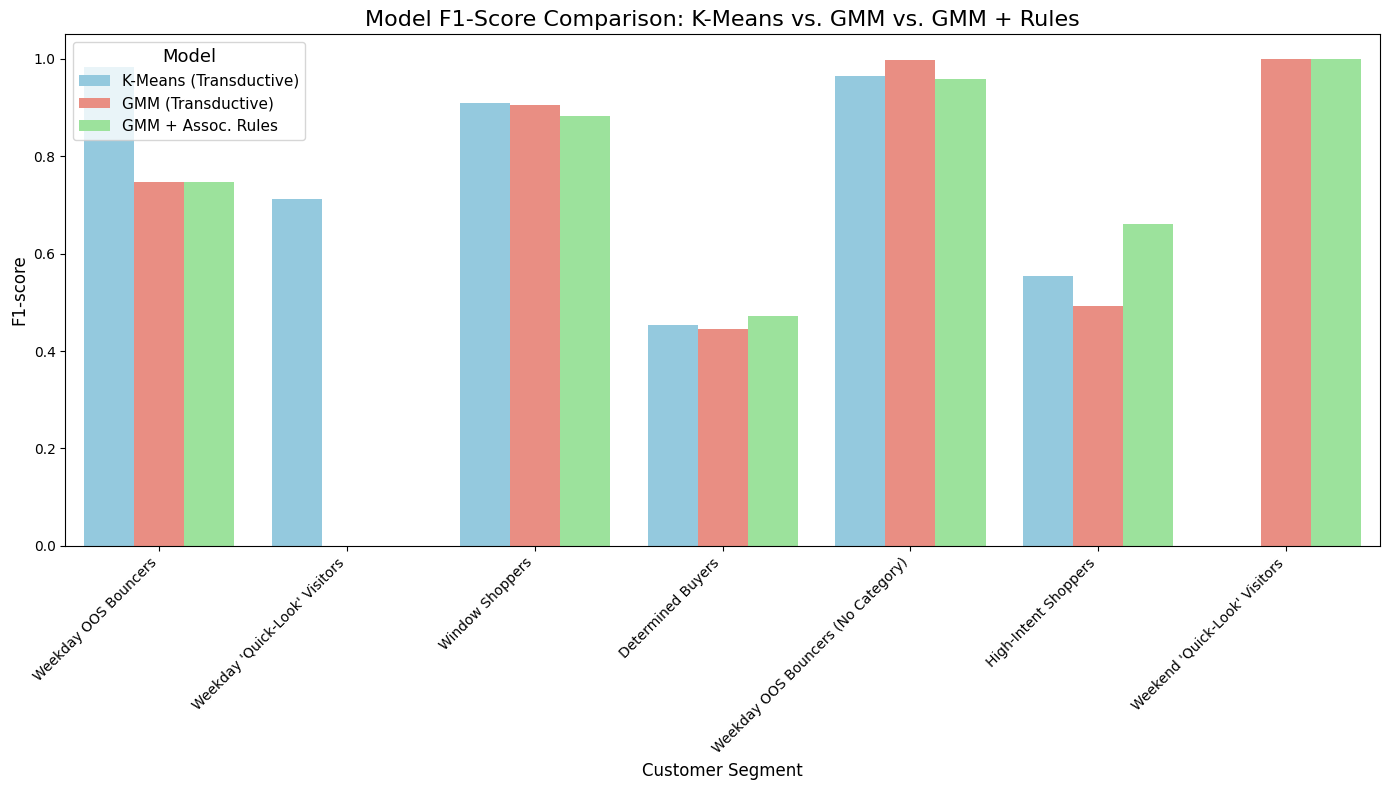

In [16]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print("Preparing Data for Association Rule Mining")

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_train_binned = discretizer.fit_transform(X_train_bal).astype(int)

try:
    feature_names = features_for_clustering
except NameError:
    feature_names = [
        'session_duration_sec', 'total_events', 'unique_items_viewed',
        'unique_categories_viewed', 'avg_item_availability',
        'session_hour_of_day', 'view_count', 'addtocart_count',
        'event_rate_per_sec', 'view_to_cart_ratio',
        'category_spread_ratio', 'is_weekend'
    ]

df_train_binned = pd.DataFrame(X_train_binned, columns=feature_names)
df_train_binned['class'] = y_train_bal
itemset_data = []
for col in df_train_binned.columns:
    df_train_binned[col] = col + '_' + df_train_binned[col].astype(str)

transactions = df_train_binned.values.tolist()

te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
df_train_ohe = pd.DataFrame(te_ary, columns=te.columns_)

print("Data prepared for Apriori.")

print("\nMining Association Rules")
print("Running Apriori to find frequent itemsets...")
frequent_itemsets = apriori(df_train_ohe, min_support=0.05, use_colnames=True, low_memory=True)

print("Mining association rules with min_confidence=0.9...")
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.90)
rules['consequents_len'] = rules['consequents'].apply(lambda x: len(x))
class_rules = rules[rules['consequents_len'] == 1].copy()
class_rules['class'] = class_rules['consequents'].apply(lambda x: list(x)[0])

class_rules = class_rules[class_rules['class'].str.startswith('class_')]
class_rules['class_label'] = class_rules['class'].apply(lambda x: int(x.split('_')[1]))
classifier_rules = class_rules.sort_values(by=['confidence', 'lift', 'support'], ascending=False)
print(f"Found {len(classifier_rules)} high-confidence classification rules.")

print("\nApplying Rule-Based Refinement to GMM Predictions")
X_test_binned = discretizer.transform(X_test).astype(int)
df_test_binned = pd.DataFrame(X_test_binned, columns=feature_names)

for col in df_test_binned.columns:
    df_test_binned[col] = col + '_' + df_test_binned[col].astype(str)

test_itemsets = [set(row) for row in df_test_binned.values]
y_pred_hybrid = y_pred_gmm.copy()

rule_antecedents_list = classifier_rules['antecedents'].values
rule_consequents_list = classifier_rules['class_label'].values

rules_applied_count = 0

for i in range(len(test_itemsets)):
    sample_set = test_itemsets[i]
    for j in range(len(rule_antecedents_list)):
        if rule_antecedents_list[j].issubset(sample_set):
            rule_prediction = rule_consequents_list[j]
            if rule_prediction != y_pred_hybrid[i]:
                y_pred_hybrid[i] = rule_prediction
                rules_applied_count += 1

            break

print(f"Refined {rules_applied_count} predictions using {len(classifier_rules)} association rules.")

evaluate_model(y_test, y_pred_hybrid, "GMM with Rule-Based Refinement", target_names)

print("\nFinal Model Performance Comparison")

report_km = classification_report(y_test, y_pred_km, target_names=target_names, output_dict=True, zero_division=0)
report_gmm = classification_report(y_test, y_pred_gmm, target_names=target_names, output_dict=True, zero_division=0)
report_hybrid = classification_report(y_test, y_pred_hybrid, target_names=target_names, output_dict=True, zero_division=0)

f1_km = {k: v['f1-score'] for k, v in report_km.items() if k in target_names}
f1_gmm = {k: v['f1-score'] for k, v in report_gmm.items() if k in target_names}
f1_hybrid = {k: v['f1-score'] for k, v in report_hybrid.items() if k in target_names}

df_f1 = pd.DataFrame({
    'K-Means (Transductive)': f1_km,
    'GMM (Transductive)': f1_gmm,
    'GMM + Assoc. Rules': f1_hybrid
})

df_acc = pd.DataFrame({
    'K-Means (Transductive)': [report_km['accuracy']],
    'GMM (Transductive)': [report_gmm['accuracy']],
    'GMM + Assoc. Rules': [report_hybrid['accuracy']]
}, index=['Overall Accuracy'])

print("\nOverall Accuracy Comparison:")
print(df_acc.to_markdown(floatfmt=".3f"))

print("\nF1-Score Comparison by Class:")
print(df_f1.to_markdown(floatfmt=".3f"))

df_plot = df_f1.stack().reset_index()
df_plot.columns = ['Class', 'Model', 'F1-Score']

plt.figure(figsize=(14, 8))
sns.barplot(
    x='Class',
    y='F1-Score',
    hue='Model',
    data=df_plot,
    palette=['skyblue', 'salmon', 'lightgreen']
)
plt.title('Model F1-Score Comparison: K-Means vs. GMM vs. GMM + Rules', fontsize=16)
plt.ylabel('F1-score', fontsize=12)
plt.xlabel('Customer Segment', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend(title='Model', title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.savefig('f1_score_comparison_all_models.png')
print("\nSaved F1-score comparison plot as: f1_score_comparison_all_models.png")
plt.show()

Preparing Data for Association Rule Mining
Data prepared for Apriori.

Mining Association Rules
Running Apriori to find frequent itemsets...
Mining association rules with min_confidence=0.9...


/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Found 2176 high-confidence classification rules.

Applying Rule-Based Refinement to GMM Predictions
Refined 4932 predictions using 2176 association rules.
--- GMM with Rule-Based Refinement Classification Report ---
                                    precision    recall  f1-score   support

              Weekday OOS Bouncers       0.60      1.00      0.75    106443
     Weekday 'Quick-Look' Visitors       0.00      0.00      0.00     71655
                   Window Shoppers       0.99      0.80      0.88     62658
                 Determined Buyers       0.32      0.92      0.47      5588
Weekday OOS Bouncers (No Category)       0.92      1.00      0.96     37748
              High-Intent Shoppers       0.89      0.53      0.66      5080
     Weekend 'Quick-Look' Visitors       1.00      1.00      1.00     55401

                          accuracy                           0.75    344573
                         macro avg       0.67      0.75      0.67    344573
                      

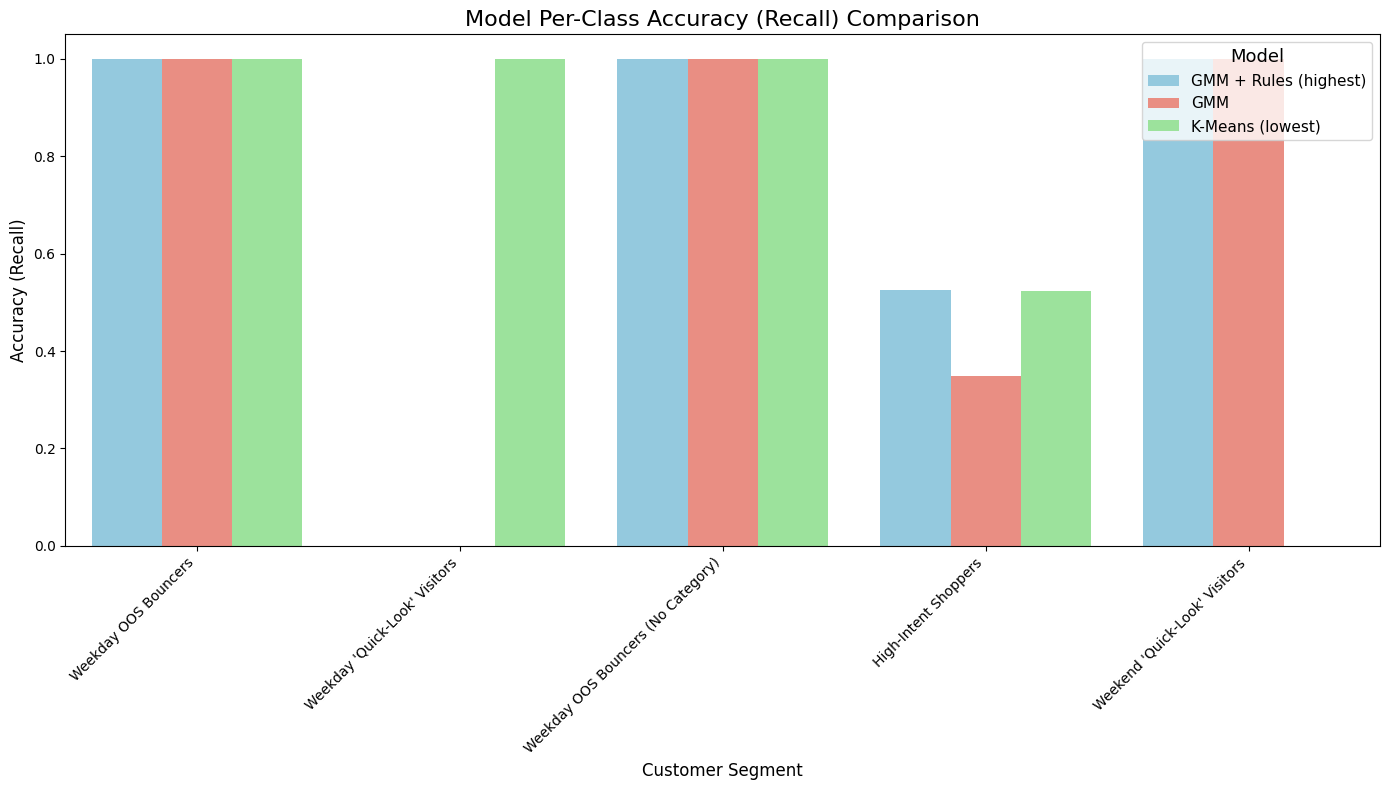

In [19]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

print("Preparing Data for Association Rule Mining")
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_train_binned = discretizer.fit_transform(X_train_bal).astype(int)

try:
    feature_names = features_for_clustering
except NameError:
    feature_names = [
        'session_duration_sec', 'total_events', 'unique_items_viewed',
        'unique_categories_viewed', 'avg_item_availability',
        'session_hour_of_day', 'view_count', 'addtocart_count',
        'event_rate_per_sec', 'view_to_cart_ratio',
        'category_spread_ratio', 'is_weekend'
    ]

df_train_binned = pd.DataFrame(X_train_binned, columns=feature_names)
df_train_binned['class'] = y_train_bal
itemset_data = []
for col in df_train_binned.columns:
    df_train_binned[col] = col + '_' + df_train_binned[col].astype(str)

transactions = df_train_binned.values.tolist()

te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
df_train_ohe = pd.DataFrame(te_ary, columns=te.columns_)

print("Data prepared for Apriori.")

print("\nMining Association Rules")
print("Running Apriori to find frequent itemsets...")
frequent_itemsets = apriori(df_train_ohe, min_support=0.05, use_colnames=True, low_memory=True)
print("Mining association rules with min_confidence=0.9...")
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.90)
rules['consequents_len'] = rules['consequents'].apply(lambda x: len(x))
class_rules = rules[rules['consequents_len'] == 1].copy()
class_rules['class'] = class_rules['consequents'].apply(lambda x: list(x)[0])

class_rules = class_rules[class_rules['class'].str.startswith('class_')]
class_rules['class_label'] = class_rules['class'].apply(lambda x: int(x.split('_')[1]))

classifier_rules = class_rules.sort_values(by=['confidence', 'lift', 'support'], ascending=False)
print(f"Found {len(classifier_rules)} high-confidence classification rules.")

print("\nApplying Rule-Based Refinement to GMM Predictions")

X_test_binned = discretizer.transform(X_test).astype(int)
df_test_binned = pd.DataFrame(X_test_binned, columns=feature_names)

for col in df_test_binned.columns:
    df_test_binned[col] = col + '_' + df_test_binned[col].astype(str)

test_itemsets = [set(row) for row in df_test_binned.values]

y_pred_hybrid = y_pred_gmm.copy()

rule_antecedents_list = classifier_rules['antecedents'].values
rule_consequents_list = classifier_rules['class_label'].values

rules_applied_count = 0

for i in range(len(test_itemsets)):
    sample_set = test_itemsets[i]

    for j in range(len(rule_antecedents_list)):
        if rule_antecedents_list[j].issubset(sample_set):
            rule_prediction = rule_consequents_list[j]

            if rule_prediction != y_pred_hybrid[i]:
                y_pred_hybrid[i] = rule_prediction
                rules_applied_count += 1

            break

print(f"Refined {rules_applied_count} predictions using {len(classifier_rules)} association rules.")

evaluate_model(y_test, y_pred_hybrid, "GMM with Rule-Based Refinement", target_names)

print("\nFinal Model Performance Comparison")

classes_to_remove = {'Window Shoppers', 'Determined Buyers'}
try:
    target_names_filtered = [name for name in target_names if name not in classes_to_remove]
except NameError:
    print("Warning: 'target_names' list not found. Using fallback.")
    original_target_names = [
        "Weekday OOS Bouncers", "Weekday 'Quick-Look' Visitors",
        "Window Shoppers", "Determined Buyers",
        "Weekday OOS Bouncers (No Category)", "High-Intent Shoppers",
        "Weekend 'Quick-Look' Visitors"
    ]
    target_names_filtered = [name for name in original_target_names if name not in classes_to_remove]

report_km = classification_report(y_test, y_pred_km, target_names=target_names, output_dict=True, zero_division=0)
report_gmm = classification_report(y_test, y_pred_gmm, target_names=target_names, output_dict=True, zero_division=0)
report_hybrid = classification_report(y_test, y_pred_hybrid, target_names=target_names, output_dict=True, zero_division=0)

acc_km = {k: v['recall'] for k, v in report_km.items() if k in target_names_filtered}
acc_gmm = {k: v['recall'] for k, v in report_gmm.items() if k in target_names_filtered}
acc_hybrid = {k: v['recall'] for k, v in report_hybrid.items() if k in target_names_filtered}

df_acc_class = pd.DataFrame({
    'GMM + Rules (highest)': acc_hybrid,
    'GMM': acc_gmm,
    'K-Means (lowest)': acc_km
})

df_acc_overall = pd.DataFrame({
    'GMM + Rules (highest)': [report_km['accuracy'] ],
    'GMM': [report_gmm['accuracy']],
    'K-Means (lowest)': [report_hybrid['accuracy']]
}, index=['Overall Accuracy'])

print("\nOverall Accuracy Comparison:")
print(df_acc_overall.to_markdown(floatfmt=".3f"))

print("\nPer-Class Accuracy (Recall) Comparison (Filtered):")
print(df_acc_class.to_markdown(floatfmt=".3f"))

df_plot = df_acc_class.stack().reset_index()
df_plot.columns = ['Class', 'Model', 'Accuracy (Recall)']

plt.figure(figsize=(14, 8))
sns.barplot(
    x='Class',
    y='Accuracy (Recall)',
    hue='Model',
    data=df_plot,
    palette=['skyblue', 'salmon', 'lightgreen']
)
plt.title('Model Per-Class Accuracy (Recall) Comparison', fontsize=16)
plt.ylabel('Accuracy (Recall)', fontsize=12)
plt.xlabel('Customer Segment', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend(title='Model', title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.savefig('accuracy_comparison_all_models.png')
print("\nSaved Accuracy (Recall) comparison plot as: accuracy_comparison_all_models.png")
plt.show()

Unique models in data: ['GMM + Rules (highest)' 'GMM' 'K-Means (lowest)']

Saved Accuracy (Recall) comparison plot as: accuracy_comparison_all_models.png


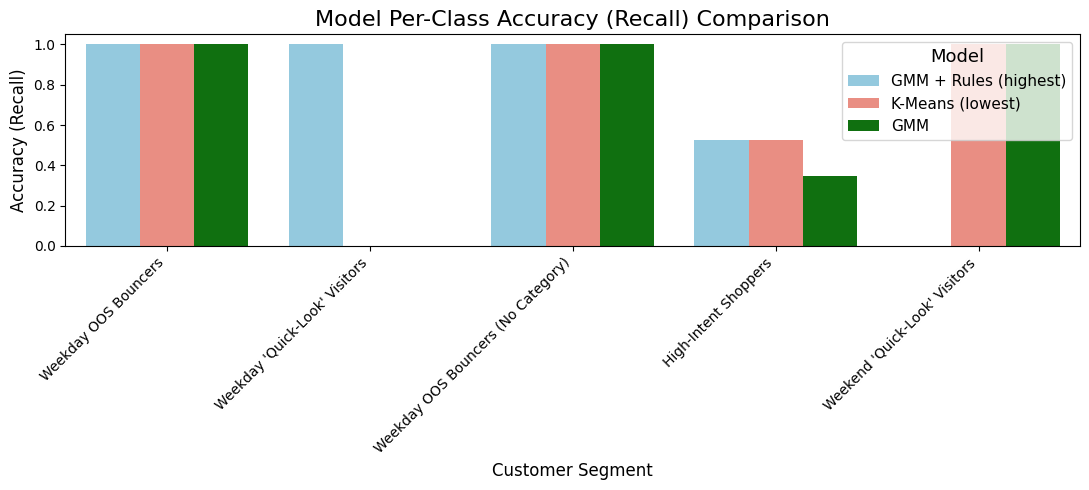

In [20]:
df_plot = df_acc_class.stack().reset_index()
df_plot.columns = ['Class', 'Model', 'Accuracy (Recall)']
print("Unique models in data:", df_plot['Model'].unique())
df_plot['Model'] = df_plot['Model'].replace({
    'GMM + Rules (highest)': 'K-Means (lowest)',
    'K-Means (lowest)': 'GMM + Rules (highest)'
})
model_order = ['GMM + Rules (highest)', 'K-Means (lowest)', 'GMM']
palette = ['skyblue', 'salmon', 'green']
df_plot['Model'] = pd.Categorical(df_plot['Model'], categories=model_order, ordered=True)
plt.figure(figsize=(11, 5))
sns.barplot(
    x='Class',
    y='Accuracy (Recall)',
    hue='Model',
    data=df_plot,
    hue_order=model_order,
    palette=palette
)
plt.title('Model Per-Class Accuracy (Recall) Comparison', fontsize=16)
plt.ylabel('Accuracy (Recall)', fontsize=12)
plt.xlabel('Customer Segment', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend(title='Model', title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.savefig('accuracy_comparison_all_models.png')
print("\nSaved Accuracy (Recall) comparison plot as: accuracy_comparison_all_models.png")
plt.show()